# Exemplo 04: Clusterização
## Identificação de base para grupo de veículos Uber
---

K-Means é um dos algoritmos de agrupamento não supervisionados mais simples e populares [1]. O objetivo é encontrar grupos nos dados, com o número de grupos/clusters representados pela variável K. O algoritmo K-Means aloca iterativamente todos os pontos de dados para o cluster mais próximo. Em cada iteração do algoritmo, cada ponto de dado é atribuído ao cluster mais próximo com base em alguma métrica, que geralmente é a distância euclidiana. As saídas do algoritmo de agrupamento K-means são os centróides dos clusters K e os rótulos dos dados. Depois que o algoritmo executa e identifica todos os grupos de um conjunto de dados, qualquer novo dado pode ser facilmente atribuído a um grupo existente. O algoritmo K-Means pode ser usado para identificar grupos desconhecidos em conjuntos de dados complexos e não rotulados.

Para efeito de comparação são também mostradoso agrupamento usando os algoritmos Bisecting k-means[2], um K-means hierárquico, e o Gaussian Mixture Model (GMM)[3], que distribui os pontos a partir de uma distribuição gaussiana.

Este exemplo usa uma base de dados de localização de chamados do Uber em Nova York. O algoritmo de clusterização agrupa os usuários e identifica os pontos ideais para o estabelecimento de uma base, de onde os carros ficarão aguardando os chamados. 

## Referências:

1. Huang, Zhexue. "Extensions to the k-means algorithm for clustering large data sets with categorical values". Data mining and knowledge discovery, Vol 2, Issue 3. pp 283-304. Springer. 1998.

2. Savaresi, Sergio M; Boley, Daniel L. "On the performance of bisecting K-means and PDDP". Proceedings of the 2001 SIAM International Conference on Data Mining. 2001

3. Reynolds, D.A.; Rose, R.C. "Robust text-independent speaker identification using Gaussian mixture speaker models". IEEE Transactions on Speech and Audio Processing. 3 (1): 72–83. January 1995.  



In [1]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
start_time = time.time()

%matplotlib inline

## Configure parameters

In [2]:
# Path to dataset file
data_path='./data/'

## Start Spark Session

In [3]:
# Create Spark Session
sc = SparkSession.builder \
     .master("local[*]") \
     .appName("Clustering") \
     .getOrCreate()

# Set evaluator
evaluator = ClusteringEvaluator()

## Reading Data

In [4]:
# Load Iris CSV dataset to Spark Dataframe
orig_data = sc.read.format("csv").options(sep=',',header='true',inferschema='true').\
            load(data_path+"uber.csv.gz")

print("Original Uber Dataframe read from CSV file")
#orig_data.dtypes
orig_data.show()

Original Uber Dataframe read from CSV file
+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|5/1/2014 0:02:00|40.7521|-73.9914|B02512|
|5/1/2014 0:06:00|40.6965|-73.9715|B02512|
|5/1/2014 0:15:00|40.7464|-73.9838|B02512|
|5/1/2014 0:17:00|40.7463|-74.0011|B02512|
|5/1/2014 0:17:00|40.7594|-73.9734|B02512|
|5/1/2014 0:20:00|40.7685|-73.8625|B02512|
|5/1/2014 0:21:00|40.7637|-73.9962|B02512|
|5/1/2014 0:21:00|40.7252|-74.0023|B02512|
|5/1/2014 0:25:00|40.7607|-73.9625|B02512|
|5/1/2014 0:25:00|40.7212|-73.9879|B02512|
|5/1/2014 0:29:00|40.7255|-73.9986|B02512|
|5/1/2014 0:32:00|40.6467|-73.7901|B02512|
|5/1/2014 0:40:00|40.7613|-73.9788|B02512|
|5/1/2014 0:56:00|40.7807|-73.9497|B02512|
|5/1/2014 1:00:00|40.7585|-73.9708|B02512|
|5/1/2014 1:02:00|40.7163|-73.9895|B02512|
|5/1/2014 1:06:00|40.7265|-73.9958|B02512|
|5/1/2014 1:13:00|40.7559|-73.9867|B02512|
|5/1/2014 1:13:00|40.7671|-73.9956|B02512|
|5/1/2014 1

### Create Clustering Matrix

In [5]:
# The feature column should join all parameters as a Vector
# Set the column names that is not part of features list
ignore = ['Date/Time', 'Base']

# list will be the value of all columns parts of features vector
list = [x for x in orig_data.columns if x not in ignore]

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
data = (assembler.transform(orig_data).select("Base","features"))

print("Final Dataframe to K-Means")
data.show()

Final Dataframe to K-Means
+------+------------------+
|  Base|          features|
+------+------------------+
|B02512|[40.7521,-73.9914]|
|B02512|[40.6965,-73.9715]|
|B02512|[40.7464,-73.9838]|
|B02512|[40.7463,-74.0011]|
|B02512|[40.7594,-73.9734]|
|B02512|[40.7685,-73.8625]|
|B02512|[40.7637,-73.9962]|
|B02512|[40.7252,-74.0023]|
|B02512|[40.7607,-73.9625]|
|B02512|[40.7212,-73.9879]|
|B02512|[40.7255,-73.9986]|
|B02512|[40.6467,-73.7901]|
|B02512|[40.7613,-73.9788]|
|B02512|[40.7807,-73.9497]|
|B02512|[40.7585,-73.9708]|
|B02512|[40.7163,-73.9895]|
|B02512|[40.7265,-73.9958]|
|B02512|[40.7559,-73.9867]|
|B02512|[40.7671,-73.9956]|
|B02512|[40.7707,-73.9944]|
+------+------------------+
only showing top 20 rows



In [6]:
#data.printSchema()
data.count()

652435

## Evaluate the number of clusters: **K**

Finding the number of cluster in clustering algorithms is crucial. One method is calculate the Silhouette 

### Clustering Silhouette

Silhouette is methodology of interpretation and validation of consistency within clusters of data. The technique provides a succinct representation of how well each object has been classified. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, near to +1, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [7]:
# Calculate the silhouette of KMeans from 2 to N clusters
# Set the max K
max_k = 50

# Initiate silhouette array with zero
silhouette = np.zeros(max_k)

# If the dataset is big, get only a sample to find the k
# geting sample 5% 
k_eval = data.sample(False, 0.05)
k_eval.count()
#k_eval.show()

32847

In [8]:
# Calculate silhouette for each k (it may be take a long time...)
for k in range(2,max_k):
    kmeans = KMeans(featuresCol='features', k=k, maxIter=5, seed=1)
    model = kmeans.fit(k_eval)
    predictions = model.transform(k_eval)
    silhouette[k] = evaluator.evaluate(predictions)

Text(0, 0.5, 'silhouette')

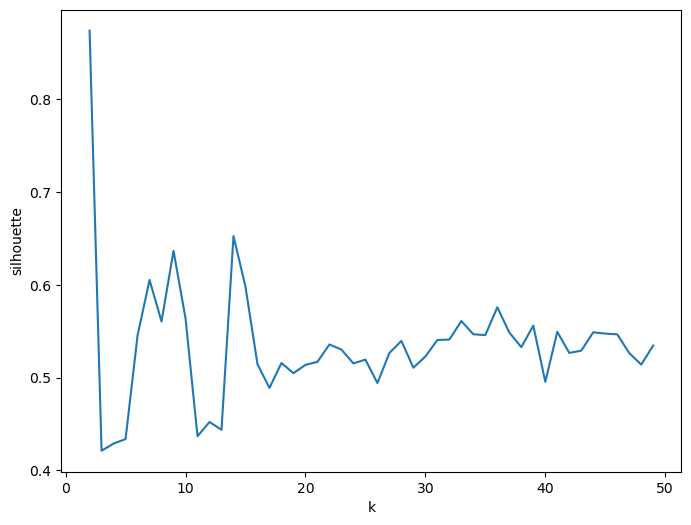

In [9]:
# Plot graph cluster number x cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,max_k),silhouette[2:max_k])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

In [10]:
# Set a good number os clusters
k = 4

## K-Means Clustering

k-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. The ML implementation includes a parallelized variant of the k-means++ method.

In [11]:
start_time_km =  time.time()

# Trains a bisecting k-means model.
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(data)

# Get centroids
centers = model.clusterCenters()

# Make predictions
predictions = model.transform(data)

# Evaluate clustering by computing Silhouette score
silhouette_km = evaluator.evaluate(predictions)

time_km = time.time() - start_time_km

print("Silhouette with squared euclidean distance = " + str(silhouette_km))
print()
print("Cluster Centers: ")
for center in centers:
    print(center)
print()    
print("Processing time (s) = %3.3f s" % (time_km))

Silhouette with squared euclidean distance = 0.41797035358580603

Cluster Centers: 
[ 40.76228668 -73.9759785 ]
[ 40.79592454 -73.87400752]
[ 40.66129902 -73.77311793]
[ 40.71764587 -73.99646476]

Processing time (s) = 16.874 s


## Bisecting k-means

*Bisecting k-means* is a kind of hierarchical clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy. *Bisecting K-means* can often be much faster than regular K-means, but it will generally produce a different clustering.

In [12]:
start_time_bk =  time.time()

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(k).setSeed(1)
model = bkm.fit(data)

# Get centroids
centers = model.clusterCenters()

# Make predictions
predictions = model.transform(data)

# Evaluate clustering by computing Silhouette score
silhouette_bk = evaluator.evaluate(predictions)

time_bk = time.time() - start_time_bk

print("Silhouette with squared euclidean distance = " + str(silhouette_bk))
print()

# Shows the result.
print("Cluster Centers: ")
for center in centers:
    print(center)

print()    
print("Processing time (s) = %3.3f s" % (time_bk))

Silhouette with squared euclidean distance = 0.430723066749752

Cluster Centers: 
[ 40.71933059 -73.99636809]
[ 40.76494649 -73.97347354]
[ 40.71202449 -73.82637419]
[ 40.90643231 -73.63304998]

Processing time (s) = 33.105 s


## Gaussian Mixture Model (GMM)

A Gaussian Mixture Model represents a composite distribution whereby points are drawn from one of k Gaussian sub-distributions, each with its own probability. The spark.ml implementation uses the expectation-maximization algorithm to induce the maximum-likelihood model given a set of samples.

In [13]:
start_time_gm =  time.time()

# Trains a GMM model.
gmm = GaussianMixture().setK(k).setSeed(1)
model = gmm.fit(data)

# Make predictions
predictions = model.transform(data)

# Evaluate clustering by computing Silhouette score
silhouette_gm = evaluator.evaluate(predictions)

time_gm = time.time() - start_time_gm

print("Silhouette with squared euclidean distance = " + str(silhouette_gm))
print()

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show()
print()    

print("Processing time (s) = %3.3f s" % (time_gm))
print()

Silhouette with squared euclidean distance = 0.5957677526264982

Gaussians shown as a DataFrame: 
+--------------------+--------------------+
|                mean|                 cov|
+--------------------+--------------------+
|[40.6586771425515...|3.519638137496068...|
|[40.7474739304729...|4.71572477309566E...|
|[40.7544855286932...|0.010724378533319...|
|[40.7128912270126...|0.001323394897610...|
+--------------------+--------------------+


Processing time (s) = 146.106 s



## Sumary

In [14]:
print("====================================================================")
print("=============  Compare Algorithm Silhouette and Time ===============")
print()
print("K-Means:                        silhouette = %3.2f    time = %3.3f s" % (silhouette_km, time_km))
print("Bisecting k-means:              silhouette = %3.2f    time = %3.3f s" % (silhouette_bk, time_bk))
print("Gaussian Mixture Model (GMM):   silhouette = %3.2f    time = %3.3f s" % (silhouette_gm, time_gm))
print("====================================================================")

=============  Compare Algorithm Silhouette and Time ===============

K-Means:                        silhouette = 0.42    time = 16.874 s
Bisecting k-means:              silhouette = 0.43    time = 33.105 s
Gaussian Mixture Model (GMM):   silhouette = 0.60    time = 146.106 s


In [15]:
sc.stop()
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 705.2605338096619 seconds ---
